## Modules importation

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import missingno as msno
import inspect
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score, make_scorer

In [3]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import gc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [4]:
import mlflow
from mlflow.tracking import MlflowClient

In [5]:
from sklearn.metrics import fbeta_score, make_scorer

In [6]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')

## Data exploration and pre-treatment

### Data exploration

In [7]:
# Functions to calculate filling percentage of features
def missing_data(x):
      return x.isnull().sum() 

def missing_data_per(x):
    return missing_data(x) *100 /len(x)

def filled_data(x):
      return len(x) - missing_data(x) 

def filled_data_per(x):
    return filled_data(x)*100/len(x)

# Function to summarize dfs
def data_info(data):
    
    # Retrieving the name of the df
    frame = inspect.currentframe().f_back
    name = [name for name, value in frame.f_locals.items() if id(value)==id(data)]
    if len(name) > 0:
        name = name[0]
    else:
        name = 'this df'
    
    # Displaying df_infos
    print('The dataframe', name, 'has', data.shape[0], 'lignes and ', data.shape[1], 'columns.')
    print('--------------------------------------------')
    
    display(data.info())
    print('--------------------------------------------')
    
    display(data.head())
    print('--------------------------------------------')
    
    display(data.describe())
    print('--------------------------------------------')
    
    pd.set_option('display.max_rows', None)
    print('Feature filling rate')
    display(filled_data_per(data))
    
    pd.set_option('display.max_rows', 60)

In [8]:
data_info(application_train)

The dataframe application_train has 307511 lignes and  122 columns.
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

--------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


--------------------------------------------
Feature filling rate


SK_ID_CURR                      100.000000
TARGET                          100.000000
NAME_CONTRACT_TYPE              100.000000
CODE_GENDER                     100.000000
FLAG_OWN_CAR                    100.000000
FLAG_OWN_REALTY                 100.000000
CNT_CHILDREN                    100.000000
AMT_INCOME_TOTAL                100.000000
AMT_CREDIT                      100.000000
AMT_ANNUITY                      99.996098
AMT_GOODS_PRICE                  99.909597
NAME_TYPE_SUITE                  99.579852
NAME_INCOME_TYPE                100.000000
NAME_EDUCATION_TYPE             100.000000
NAME_FAMILY_STATUS              100.000000
NAME_HOUSING_TYPE               100.000000
REGION_POPULATION_RELATIVE      100.000000
DAYS_BIRTH                      100.000000
DAYS_EMPLOYED                   100.000000
DAYS_REGISTRATION               100.000000
DAYS_ID_PUBLISH                 100.000000
OWN_CAR_AGE                      34.009190
FLAG_MOBIL                      100.000000
FLAG_EMP_PH

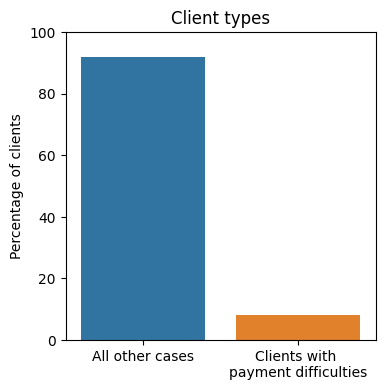

In [9]:
# 'Target' Feature 
temp = application_train.TARGET.value_counts() 
df1 = pd.DataFrame({'labels': temp.index,
                   'values': (temp.values/len(application_train))*100})

# Plot
plt.figure(figsize = (4,4))
plt.title('Client types')
sns.set_color_codes("pastel")
bar = sns.barplot(x = 'labels', y="values", data=df1)
bar.set_ylim(0,100)
bar.set(ylabel='Percentage of clients')
bar.set(xlabel=None)
bar.set_xticklabels(['All other cases', 'Clients with \npayment difficulties'])
locs, labels = plt.xticks()
plt.show()

In [10]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
        
        sns.set_color_codes("pastel")
        
        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        
        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

In [11]:
# Feature selection for exploration
important_features=['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

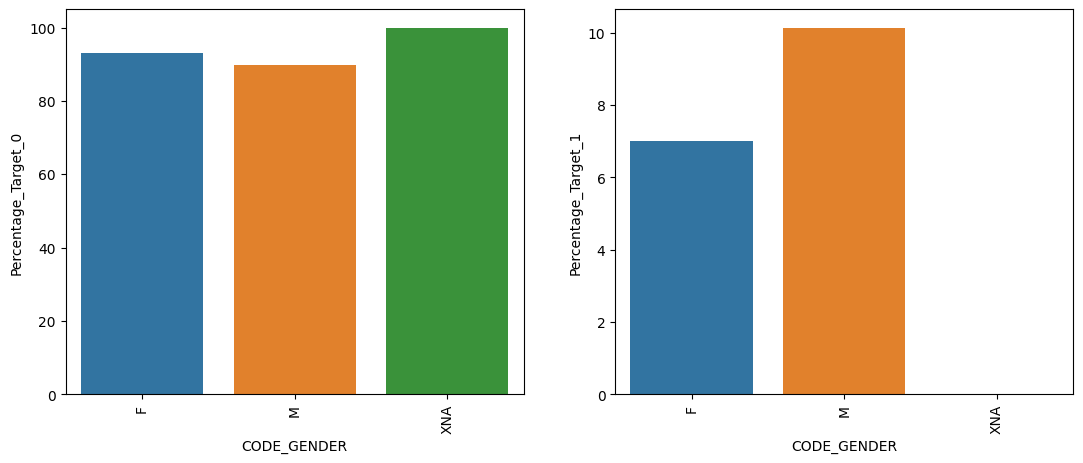

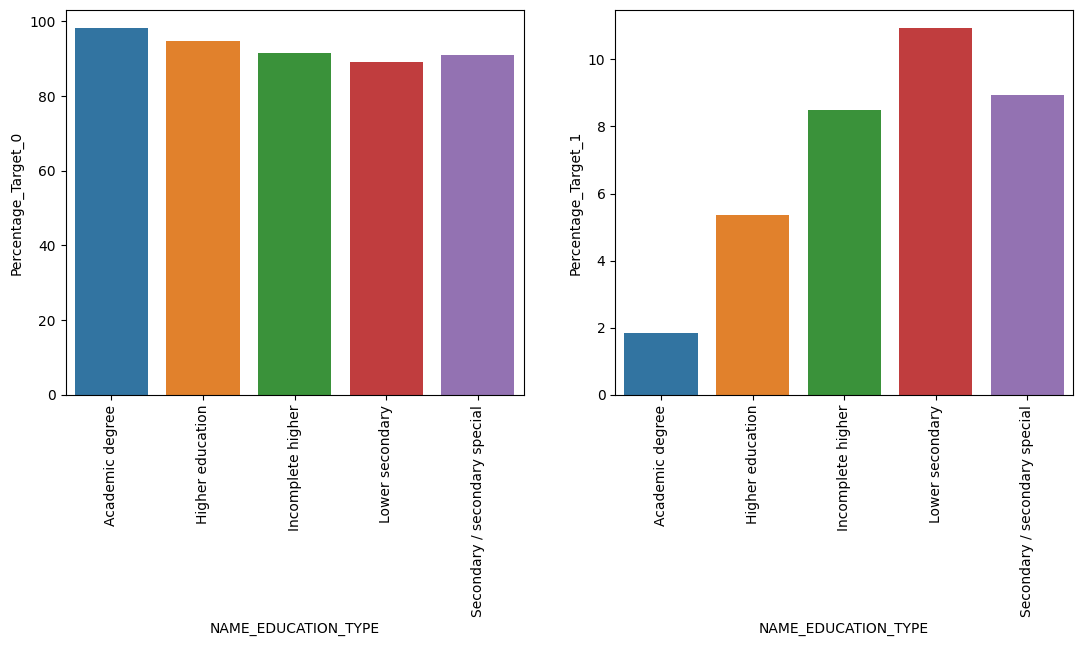

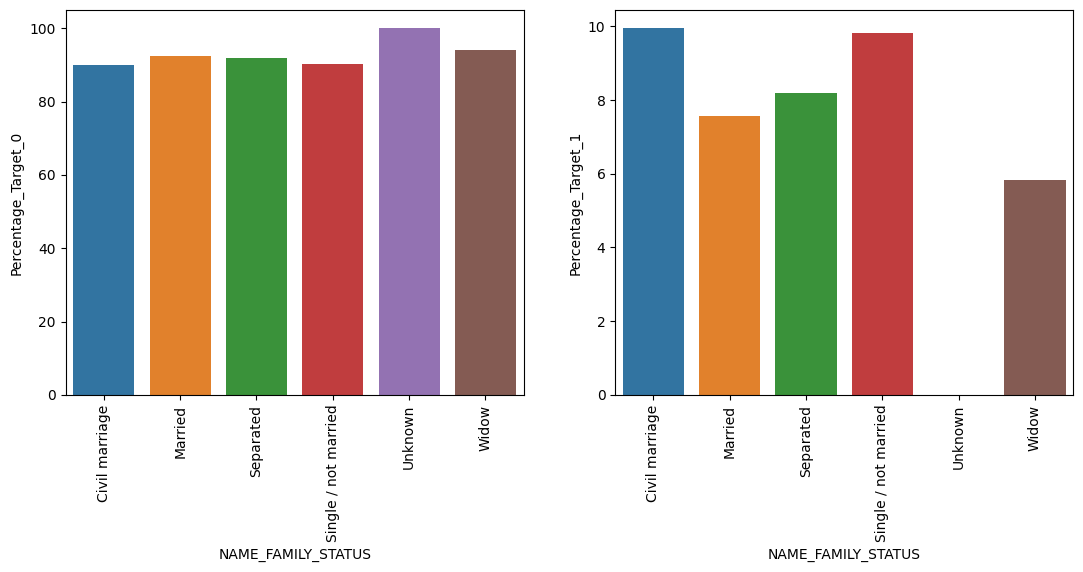

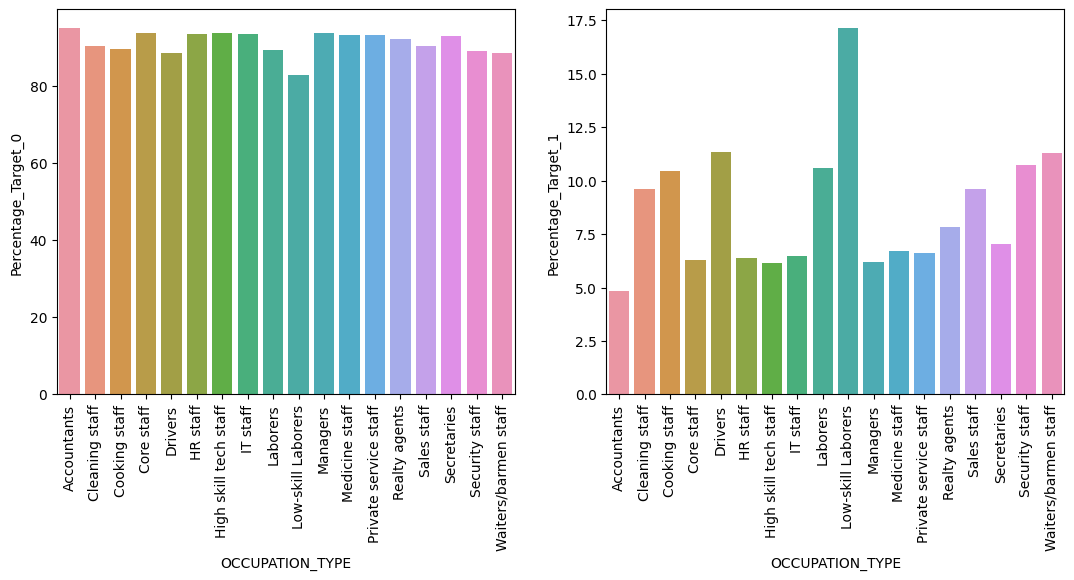

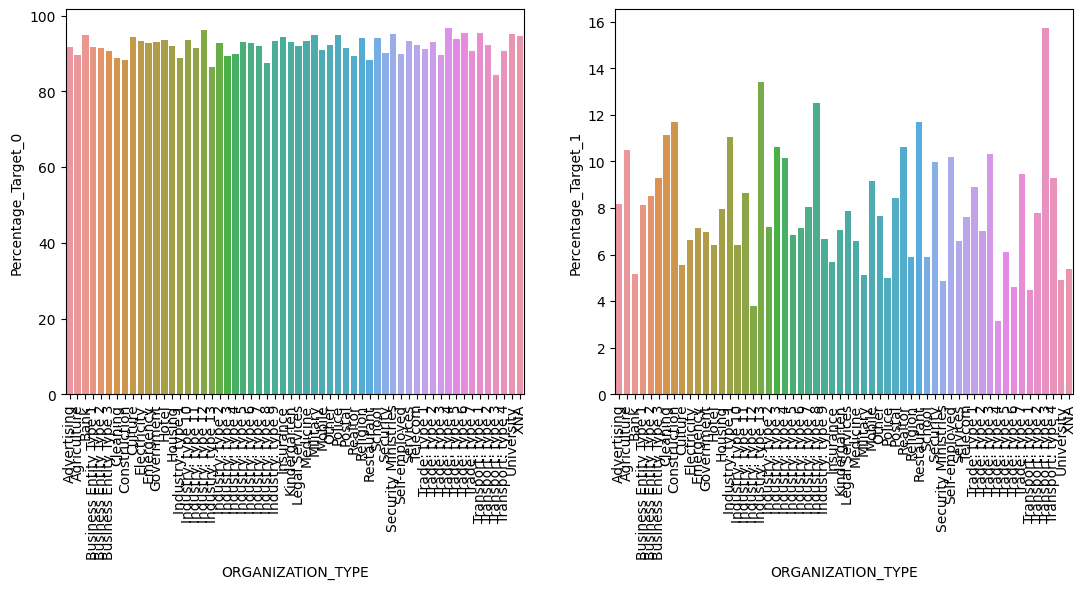

In [12]:
cat_stats(application_train,important_features)

### Feature engeneering 

In [13]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [14]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # Concatenate dataframes
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
     
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [15]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [16]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [17]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [18]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [19]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [20]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [21]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    return df

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 32s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 17s
Installments payments df shape: (339587, 26)
Process installments payments - done in 38s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 21s
Full model run - done in 134s


### Handling missing data 

In [22]:
data_info(df)

The dataframe df has 356251 lignes and  797 columns.
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(133), float64(606), int64(42), object(16)
memory usage: 1.8+ GB


None

--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,3.559730e+05,...,103558.000000,103558.000000,102866.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,102866.0,103558.000000
mean,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,5.280212e+05,...,0.000059,0.004954,0.000060,0.003583,0.106781,0.002955,0.0,0.0,0.0,37.083683
std,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,3.660657e+05,...,0.000846,0.070209,0.000849,0.031014,1.272522,0.019938,0.0,0.0,0.0,33.483627
min,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.000000
50%,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.000000
75%,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.000000
max,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,0.024390,1.000000,0.024390,1.000000,62.000000,0.500000,0.0,0.0,0.0,192.000000


--------------------------------------------
Feature filling rate


SK_ID_CURR                                                               100.000000
TARGET                                                                    86.317512
CODE_GENDER                                                              100.000000
FLAG_OWN_CAR                                                             100.000000
FLAG_OWN_REALTY                                                          100.000000
CNT_CHILDREN                                                             100.000000
AMT_INCOME_TOTAL                                                         100.000000
AMT_CREDIT                                                               100.000000
AMT_ANNUITY                                                               99.989895
AMT_GOODS_PRICE                                                           99.921965
REGION_POPULATION_RELATIVE                                               100.000000
DAYS_BIRTH                                                               100

##### Target feature

In [23]:
# Removing rows without target content 
target_mask = df['TARGET'].isna()

In [24]:
df = df[~target_mask]
df.shape

(307507, 797)

In [25]:
filled_data_per(df['TARGET'])

100.0

##### Infinite values

In [26]:
# Visualizing infinite values (positive and negative) and deleting them
infinite_mask = (df == np.inf) | (df == -np.inf)
rows_infinite = df[infinite_mask.any(axis=1)]

In [27]:
rows_infinite.shape

(19, 797)

In [28]:
df = df.loc[~infinite_mask.any(axis=1)]

In [29]:
df.shape

(307488, 797)

##### Feature filling rate

In [30]:
# Calculate the filling rates for all features
filling_rates = filled_data_per(df)

# Selecting features filled at 60% minimum
low_fill_rate_columns = filling_rates[filling_rates < 60]

In [31]:
low_fill_rate_test = low_fill_rate_columns.index.tolist()

In [32]:
import pickle

with open('selected_columns.pkl', 'wb') as file:
    pickle.dump(low_fill_rate_test, file)

In [33]:
print(low_fill_rate_columns)

OWN_CAR_AGE                         34.008807
EXT_SOURCE_1                        43.620889
APARTMENTS_AVG                      49.251678
BASEMENTAREA_AVG                    41.485196
YEARS_BEGINEXPLUATATION_AVG         51.220861
                                      ...    
CC_NAME_CONTRACT_STATUS_nan_MAX     28.261265
CC_NAME_CONTRACT_STATUS_nan_MEAN    28.261265
CC_NAME_CONTRACT_STATUS_nan_SUM     28.261265
CC_NAME_CONTRACT_STATUS_nan_VAR     28.055729
CC_COUNT                            28.261265
Length: 245, dtype: float64


In [34]:
# Dropping columns
df2 = df.drop(columns=low_fill_rate_columns.index)

In [35]:
data_info(df2)

The dataframe df2 has 307488 lignes and  552 columns.
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 307488 entries, 0 to 307510
Columns: 552 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: bool(133), float64(377), int64(42)
memory usage: 1.0 GB


None

--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,307488.000000,307488.000000,307488.000000,307488.000000,307488.000000,307488.000000,3.074880e+05,3.074880e+05,307476.000000,3.072100e+05,...,2.916200e+05,2.916200e+05,2.916120e+05,2.916120e+05,2.916120e+05,2.916200e+05,291612.000000,291612.000000,291620.000000,291620.000000
mean,278179.876034,0.080728,0.658357,0.340104,0.306327,0.417041,1.687981e+05,5.990248e+05,27108.280251,5.383935e+05,...,1.839246e+04,6.724146e+05,5.198268e+03,1.381722e+05,1.875347e+04,6.785579e+05,-327.792262,-920.932051,-41719.109169,39.745837
std,102790.058306,0.272418,0.474261,0.473745,0.460968,0.722117,2.371314e+05,4.024973e+05,14493.428904,3.694508e+05,...,2.333817e+04,8.800961e+05,1.442489e+04,2.477853e+05,2.510498e+04,9.161543e+05,536.885948,597.020410,56340.148976,40.739000
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,1.890000e-01,9.450000e-01,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.000000,1.000000
25%,189142.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,7.799490e+03,1.346729e+05,4.104000e+01,1.409710e+04,7.478122e+03,1.308232e+05,-384.000000,-1311.794828,-49349.000000,12.000000
50%,278202.500000,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,1.257267e+04,3.283588e+05,2.315160e+03,3.600000e+04,1.222571e+04,3.186057e+05,-66.000000,-807.541508,-21127.000000,25.000000
75%,367141.250000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,2.137574e+04,8.432480e+05,7.105871e+03,1.329750e+05,2.135124e+04,8.330687e+05,-26.000000,-431.594768,-6811.000000,51.000000
max,456255.000000,1.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,2.504590e+06,2.327473e+07,2.504590e+06,3.771488e+06,2.504590e+06,2.553705e+07,-1.000000,-3.000000,0.000000,372.000000


--------------------------------------------
Feature filling rate


SK_ID_CURR                                                               100.000000
TARGET                                                                   100.000000
CODE_GENDER                                                              100.000000
FLAG_OWN_CAR                                                             100.000000
FLAG_OWN_REALTY                                                          100.000000
CNT_CHILDREN                                                             100.000000
AMT_INCOME_TOTAL                                                         100.000000
AMT_CREDIT                                                               100.000000
AMT_ANNUITY                                                               99.996097
AMT_GOODS_PRICE                                                           99.909590
REGION_POPULATION_RELATIVE                                               100.000000
DAYS_BIRTH                                                               100

In [36]:
df2.dtypes.value_counts()

float64    377
bool       133
int64       42
Name: count, dtype: int64

#### Imputing numerical data 

In [37]:
# Select only boolean columns
boolean_features = df2.select_dtypes(include=['bool'])

# Select only numerical columns
numerical_features = df2.select_dtypes(include=['float64', 'int64'])

# Create a SimpleImputer instance for numerical columns
numerical_imputer = SimpleImputer(strategy='median')
imputed_numerical_features = numerical_imputer.fit_transform(numerical_features)
imputed_numerical_df = pd.DataFrame(imputed_numerical_features, columns=numerical_features.columns)

# Reset the indexes of boolean_features
boolean_features.reset_index(drop=True, inplace=True)

# Concatenate boolean features back to the imputed DataFrame
imputed_df = pd.concat([imputed_numerical_df, boolean_features], axis=1)

In [38]:
data_info(imputed_df)

The dataframe imputed_df has 307488 lignes and  552 columns.
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307488 entries, 0 to 307487
Columns: 552 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: bool(133), float64(419)
memory usage: 1022.0 MB


None

--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,False,False,True,False,True,False
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,False,True,False,False,False,False,False,False,True,False
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,False,False
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,False,False
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,False,False


--------------------------------------------


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,307488.000000,307488.000000,307488.000000,307488.000000,307488.000000,307488.000000,3.074880e+05,3.074880e+05,307488.000000,3.074880e+05,...,3.074880e+05,3.074880e+05,3.074880e+05,3.074880e+05,3.074880e+05,3.074880e+05,307488.000000,307488.000000,307488.000000,307488.000000
mean,278179.876034,0.080728,0.658357,0.340104,0.306327,0.417041,1.687981e+05,5.990248e+05,27108.194188,5.383136e+05,...,1.809213e+04,6.546596e+05,5.049410e+03,1.328969e+05,1.841643e+04,6.599824e+05,-314.275591,-915.077551,-40656.447900,38.984874
std,102790.058306,0.272418,0.474261,0.473745,0.460968,0.722117,2.371314e+05,4.024973e+05,14493.152638,3.692933e+05,...,2.276445e+04,8.604596e+05,1.406204e+04,2.423606e+05,2.449092e+04,8.957486e+05,526.041639,581.944817,55055.962757,39.807793
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,1.890000e-01,9.450000e-01,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.000000,1.000000
25%,189142.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,8.040967e+03,1.415543e+05,4.936500e+01,1.477046e+04,7.710414e+03,1.376129e+05,-359.000000,-1281.545139,-46851.250000,12.000000
50%,278202.500000,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,1.257267e+04,3.283588e+05,2.315160e+03,3.600000e+04,1.222571e+04,3.186057e+05,-66.000000,-807.541508,-21127.000000,25.000000
75%,367141.250000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,2.059858e+04,7.964152e+05,6.758651e+03,1.219006e+05,2.052909e+04,7.864815e+05,-27.000000,-450.500000,-7395.000000,48.000000
max,456255.000000,1.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,2.504590e+06,2.327473e+07,2.504590e+06,3.771488e+06,2.504590e+06,2.553705e+07,-1.000000,-3.000000,0.000000,372.000000


--------------------------------------------
Feature filling rate


SK_ID_CURR                                                               100.0
TARGET                                                                   100.0
CODE_GENDER                                                              100.0
FLAG_OWN_CAR                                                             100.0
FLAG_OWN_REALTY                                                          100.0
CNT_CHILDREN                                                             100.0
AMT_INCOME_TOTAL                                                         100.0
AMT_CREDIT                                                               100.0
AMT_ANNUITY                                                              100.0
AMT_GOODS_PRICE                                                          100.0
REGION_POPULATION_RELATIVE                                               100.0
DAYS_BIRTH                                                               100.0
DAYS_EMPLOYED                                       

#### Data exploration on final df

In [ ]:
# Finding correlations with the target and sort
correlations = imputed_df.corr()['TARGET'].sort_values()

# Selecting the top 15 most correlated features
top_correlated_features = correlations.head(15).index

# Creating a correlation matrix for the selected features
correlation_matrix = imputed_df[top_correlated_features].corr()

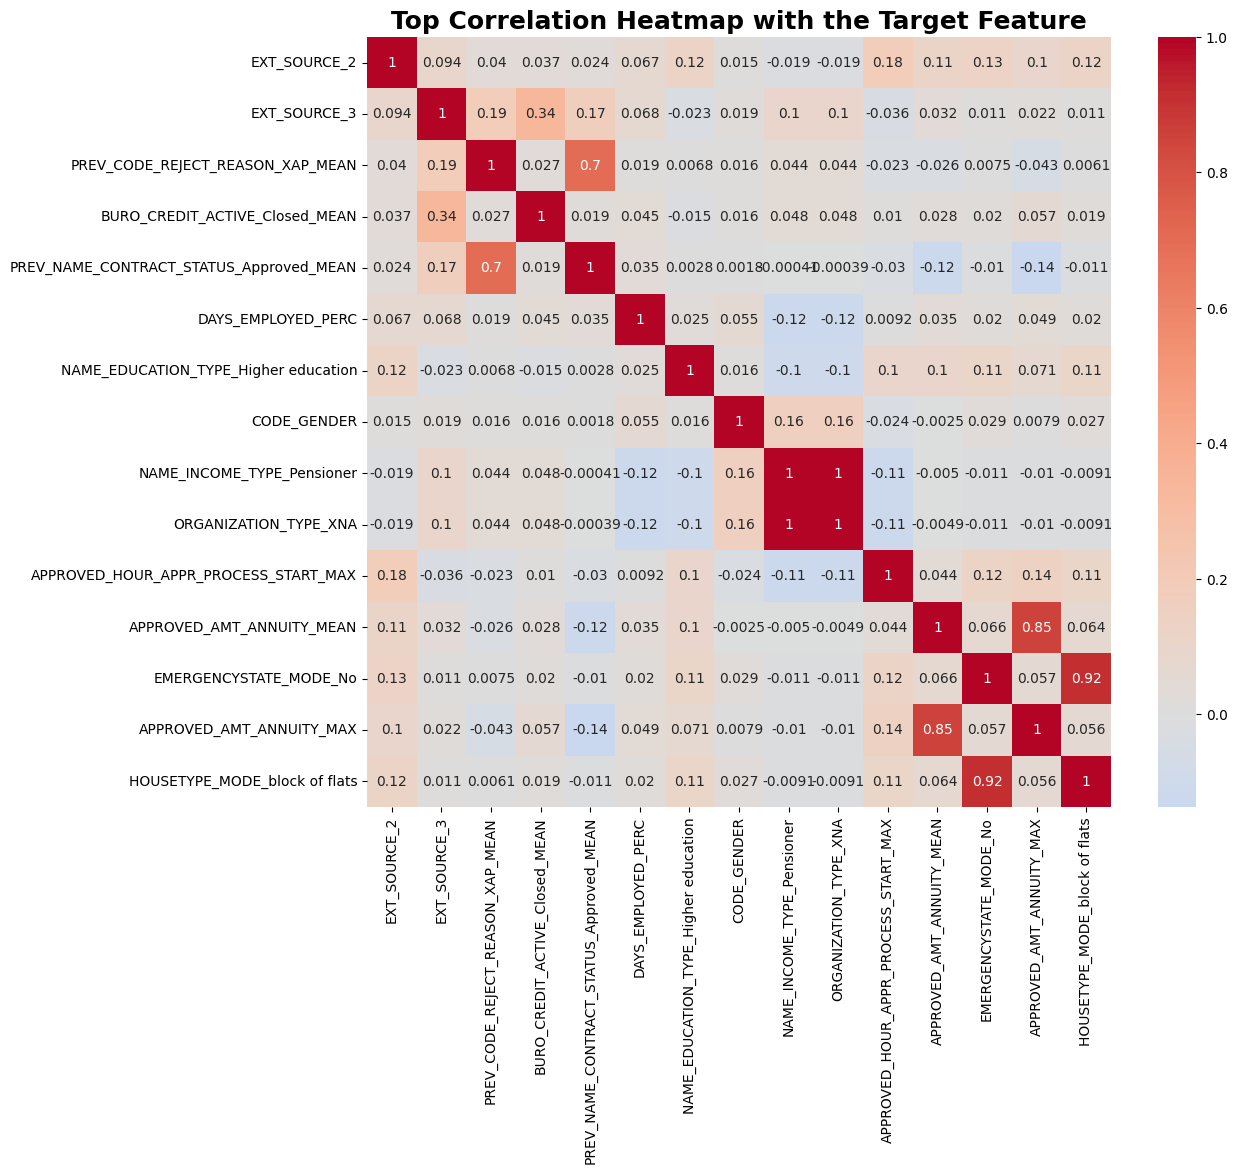

In [42]:
# Heatmap
plt.figure(figsize=(12, 10))  # Adjust the figsize as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Top Correlation Heatmap with the Target Feature', fontsize=18, weight = 'bold')
plt.show()

In [39]:
#Matching the app_train and test features
feature_names_df1 = imputed_df.columns.tolist()

import pickle
with open('feature_names_df1.pkl', 'wb') as file:
    pickle.dump(feature_names_df1, file)

In [40]:
# List of feature to remove
features_to_remove = ['NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown']

final_df = imputed_df.drop(columns=features_to_remove)

#### Saving final df

In [41]:
final_df.to_csv('df_final.csv', index= False)

In [57]:
final_df['SK_ID_CURR'].dtypes

dtype('float64')

In [56]:
final_df.drop(columns = 'TARGET').sample(frac=0.01, random_state=42).to_csv('df_sample.csv', index = False)

## Modelisation

### Splitting training and testing dataset

In [42]:
# Full dataset is too big for modelisation so selecting only x% 
sampled_df = final_df.sample(frac=0.5, random_state=27)

In [43]:
X = sampled_df.drop(columns='TARGET').copy()
y = sampled_df['TARGET'].copy()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Scoring and metrics

In [45]:
def custom_metric(y, y_pred):
    FP = np.sum( (y==0) & (y_pred==1) )
    FN = np.sum( (y==1) & (y_pred==0) )

    SM = (10 * FN) + FP 
    return SM

custom_scorer = make_scorer(custom_metric, greater_is_better=True )

In [58]:
def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(conf_mat)
    
    accuracy = accuracy_score(yval, yval_pred)
    precision = precision_score(yval, yval_pred)
    recall = recall_score(yval, yval_pred)
    f1 = f1_score(yval, yval_pred)
    f2 = fbeta_score(yval, yval_pred, beta=2)
    rocauc = roc_auc_score(yval, yval_pred)
    custom_sm = custom_metric(yval, yval_pred)
    feature_importances = model.named_steps['model'].feature_importances_
    total_importance = np.sum(feature_importances)
    feature_importances /= total_importance

    print(f'Accuracy score    : {accuracy:.3}')
    print(f'Precision score   : {precision:.3}')
    print(f'Recall score      : {recall:.3}')
    print(f'F1 score          : {f1:.3}')
    print(f'F2 score          : {f2:.3}')
    print(f'ROC AUC score      : {rocauc:.3}')
    print(f'Custom metric : {custom_sm:.3f}')
    
    # Log metrics to MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("f2_score", f2)
    mlflow.log_metric("roc_auc", rocauc)
    mlflow.log_metric("custom_metric", custom_sm)
    np.save("best_model_feature_importances.npy", feature_importances)
    mlflow.log_artifact("best_model_feature_importances.npy")
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
   
    # Show plot
    plt.show()

### Simple model

##### Without adjusting to the oversampling of the data

Running Logistic Regression
[[35340     9]
 [ 3085     2]]
Accuracy score    : 0.92
Precision score   : 0.182
Recall score      : 0.000648
F1 score          : 0.00129
F2 score          : 0.000809
ROC AUC score      : 0.5
Custom metric : 30859.000



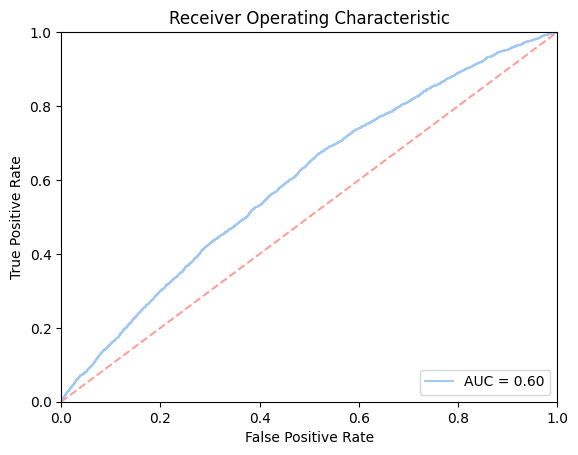

C:\Users\elois\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Running Decision Tree
[[32210  3139]
 [ 2598   489]]
Accuracy score    : 0.851
Precision score   : 0.135
Recall score      : 0.158
F1 score          : 0.146
F2 score          : 0.153
ROC AUC score      : 0.535
Custom metric : 29119.000



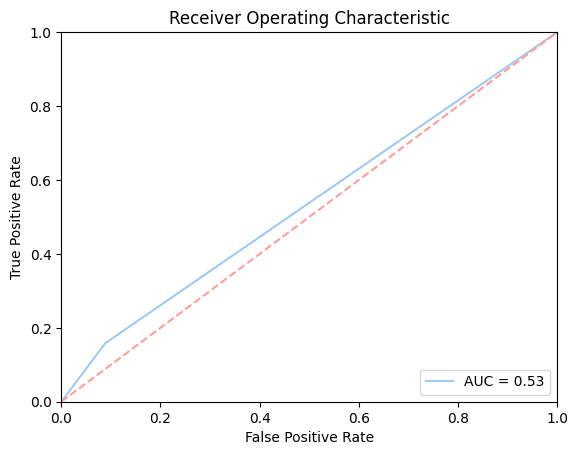

Running Linear Discriminant Analysis
[[35141   208]
 [ 2943   144]]
Accuracy score    : 0.918
Precision score   : 0.409
Recall score      : 0.0466
F1 score          : 0.0837
F2 score          : 0.0567
ROC AUC score      : 0.52
Custom metric : 29638.000



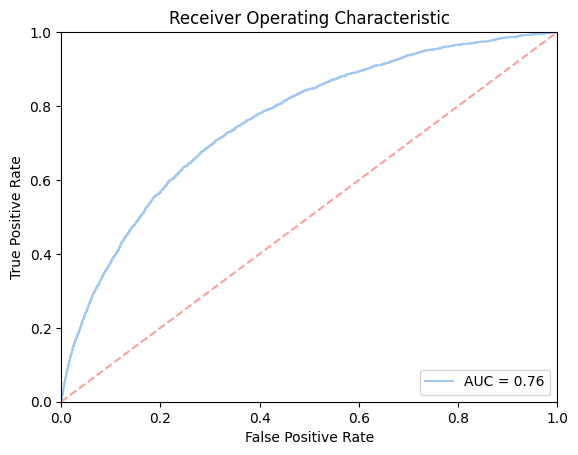

In [64]:
# Define the estimators
estimators = {
    'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

# Start an MLflow experiment
mlflow.set_experiment("Simple_Models_Experiment")

# Loop through the estimators and train models
for name, model in estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Train the model on the selected features
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # Print the metrics of the model
        model_eval(model, X_test, y_test)
      
        # Log parameters and metrics to MLflow
        mlflow.log_params({"model": name})
        
        # Log model artifact
        model_path = "models/" + name + ".joblib"
        mlflow.sklearn.log_model(model, model_path)
        
        # End MLFlow run
        mlflow.end_run()

##### Adjusting to the oversampling

In [47]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [48]:
imblearn_pipeline = Pipeline([
    ('smote', SMOTE()),  
    ('model', None)   
])

##### Setting the ML flow uri

In [49]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

##### Dummy classifier

In [65]:
# Create an imbalanced pipeline with SMOTE and DummyClassifier
imblearn_pipeline = Pipeline([
    ('smote', SMOTE()),  
    ('model', DummyClassifier(strategy='most_frequent', random_state=1))
])

# Fit the imbalanced pipeline to the training data
imblearn_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = imblearn_pipeline.predict_proba(X_test)[:, 1]

# Print the metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     35349
         1.0       0.00      0.00      0.00      3087

    accuracy                           0.92     38436
   macro avg       0.46      0.50      0.48     38436
weighted avg       0.85      0.92      0.88     38436



C:\Users\elois\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elois\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elois\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic regression, decision tree and Linear discriminant analysis

Running Logistic Regression
[[22181 13168]
 [ 1287  1800]]
Accuracy score    : 0.624
Precision score   : 0.12
Recall score      : 0.583
F1 score          : 0.199
F2 score          : 0.329
ROC AUC score      : 0.605
Custom metric : 26038.000



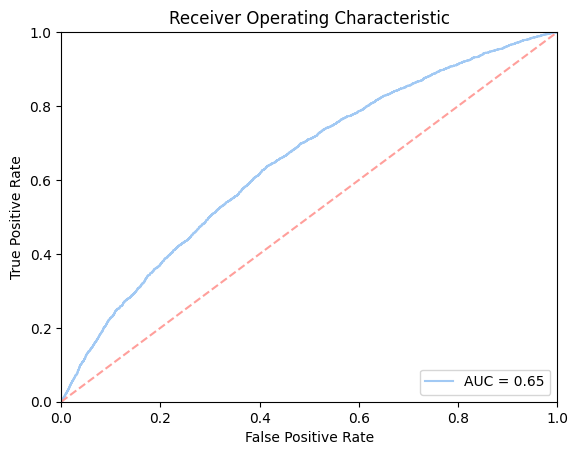

Best parameters for Logistic Regression: {'model__C': 10}

Running Decision Tree
[[35160   189]
 [ 3069    18]]
Accuracy score    : 0.915
Precision score   : 0.087
Recall score      : 0.00583
F1 score          : 0.0109
F2 score          : 0.00717
ROC AUC score      : 0.5
Custom metric : 30879.000



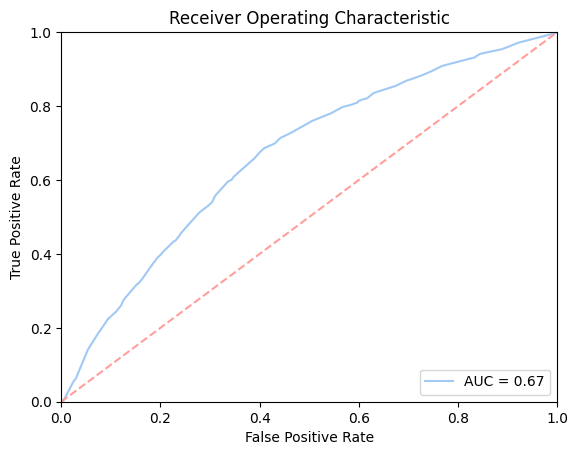

Best parameters for Decision Tree: {'model__max_depth': 10}

Running Linear Discriminant Analysis


C:\Users\elois\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\elois\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\elois\anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\elois\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "C:\Users\elois\anaconda3\l

[[35347     2]
 [ 3086     1]]
Accuracy score    : 0.92
Precision score   : 0.333
Recall score      : 0.000324
F1 score          : 0.000647
F2 score          : 0.000405
ROC AUC score      : 0.5
Custom metric : 30862.000



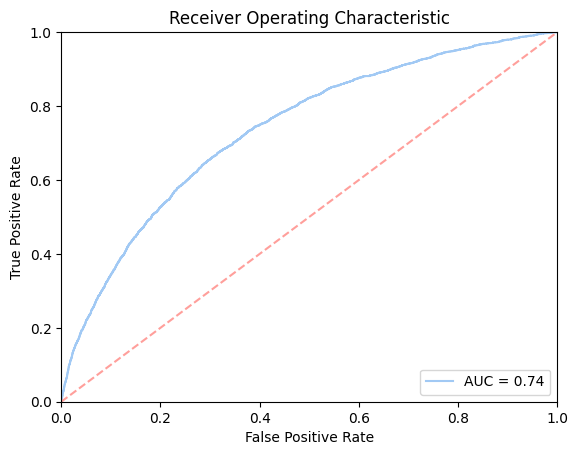

Best parameters for Linear Discriminant Analysis: {'model__solver': 'svd'}



In [66]:
# Define the estimators and their corresponding hyperparameter grids
estimators = {
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'model__C': [0.001, 0.01, 0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'model__max_depth': [None, 10, 20, 30]}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {'model__solver': ['svd', 'lsqr', 'eigen']})
}

# Start an MLflow experiment
mlflow.set_experiment("Simple_Models_Experiment_cv_smote")

# Loop through the estimators and perform GridSearchCV
for name, (model, param_grid) in estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Set the model in the imblearn pipeline
        imblearn_pipeline.set_params(model=model)

        # Define GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(imblearn_pipeline, param_grid, cv=3, scoring='roc_auc')

        # Fit GridSearchCV on the training data
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions on the test data
        y_pred = best_model.named_steps['model'].predict_proba(X_test)[:, 1]

        # Print the metrics of the best model
        model_eval(best_model, X_test, y_test)
        
        # Log best parameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
      
        # Log model artifact
        model_path = "models/" + name + "_best_model.joblib"
        mlflow.sklearn.log_model(best_model, model_path)
        
        # End MLFlow run
        mlflow.end_run()

        print(f"Best parameters for {name}: {best_params}\n")

### XGBoost

In [ ]:
# Define the estimators and their corresponding hyperparameter grids
estimators = {
    'XGBoost': (XGBClassifier(n_estimators=100, subsample=0.4, random_state=1), {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 6, 9],
        'model__learning_rate': [0.01, 0.1, 0.3]
    })
}

# Start an MLflow experiment
mlflow.set_experiment("xgb_smote_cv_3")

# Loop through the estimators and perform GridSearchCV
for name, (model, param_grid) in estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Set the model in the imblearn pipeline
        imblearn_pipeline.set_params(model=model)

        # Define GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(imblearn_pipeline, param_grid, cv=3, scoring='roc_auc')

        # Fit GridSearchCV on the training data
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        best_xgb_model = grid_search.best_estimator_

        # Make predictions on the test data
        y_pred = best_xgb_model.named_steps['model'].predict_proba(X_test)[:, 1]

        # Print the metrics of the best model
        model_eval(best_xgb_model, X_test, y_test)

        # Log best hyperparameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log model artifact
        model_path = "models/" + name + "_best_model.joblib"
        mlflow.sklearn.log_model(best_xgb_model, model_path)

        # End MLFlow run
        mlflow.end_run()

        print(f"Best parameters for {name}: {best_params}\n")

Running XGBoost


#### Random Forest

2023/09/05 20:33:16 INFO mlflow.tracking.fluent: Experiment with name 'rf_smote_cv' does not exist. Creating a new experiment.


Running Random Forest
[[35234   115]
 [ 3029    58]]
Accuracy score    : 0.918
Precision score   : 0.335
Recall score      : 0.0188
F1 score          : 0.0356
F2 score          : 0.0232
ROC AUC score      : 0.508
Custom metric : 30405.000



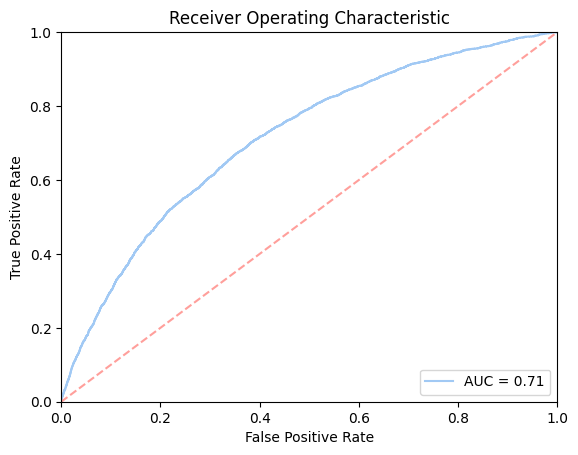

Best parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 150}



In [68]:
# Define the estimators and their corresponding hyperparameter grids
estimators = {
    'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=1), {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    })
}

# Start an MLflow experiment
mlflow.set_experiment("rf_smote_cv")

# Loop through the estimators and perform GridSearchCV
for name, (model, param_grid) in estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Set the model in the imblearn pipeline
        imblearn_pipeline.set_params(model=model)

        # Define GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(imblearn_pipeline, param_grid, cv=3, scoring='roc_auc')

        # Fit GridSearchCV on the training data
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        best_rf_model = grid_search.best_estimator_

        # Make predictions on the test data
        y_pred = best_model.named_steps['model'].predict_proba(X_test)[:, 1]

        # Print the metrics of the best model
        model_eval(best_rf_model, X_test, y_test)

        # Log best hyperparameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log model artifact
        model_path = "models/" + name + "_best_model.joblib"
        mlflow.sklearn.log_model(best_rf_model, model_path)

        # End MLFlow run
        mlflow.end_run()

        print(f"Best parameters for {name}: {best_params}\n")

##### SVM

In [ ]:
# Define the estimators and their corresponding hyperparameter grids
estimators = {
    'SVM': (SVC(probability=True, random_state=1), {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'poly'],
    })
}

# Start an MLflow experiment
mlflow.set_experiment("svm_smote_grid_search")

# Loop through the estimators and perform GridSearchCV
for name, (model, param_grid) in estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Set the model in the imblearn pipeline
        imblearn_pipeline.set_params(model=model)

        # Define GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(imblearn_pipeline, param_grid, cv=3, scoring='roc_auc')

        # Fit GridSearchCV on the training data
        grid_search.fit(X_train, y_train)

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions on the test data
        y_pred = best_model.named_steps['model'].predict_proba(X_test)[:, 1]

        # Print the metrics of the best model
        model_eval(best_model, X_test, y_test)

        # Log best hyperparameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log model artifact
        model_path = "models/" + name + "_best_model.joblib"
        mlflow.sklearn.log_model(best_model, model_path)

        # End MLFlow run
        mlflow.end_run()

        print(f"Best parameters for {name}: {best_params}\n")

Running SVM


### Feature importance 

In [ ]:
import shap

In [ ]:
pip install shap xgboost


In [ ]:
with mlflow.start_run():
    # Train your XGBoost model
    xgb_model = imblearn_pipeline.named_steps['model']
    xgb_model.fit(X_train, y_train)

    # Initialize the SHAP explainer
    explainer = shap.Explainer(xgb_model)

    # Calculate SHAP values for a set of data (e.g., your test data)
    shap_values = explainer.shap_values(X_test)

    # Log the model artifact
    mlflow.sklearn.log_model(xgb_model, "xgb_model")

    # Plot and save the SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
    plt.savefig("shap_summary_plot.png")

    # Log the SHAP summary plot as an artifact
    mlflow.log_artifact("shap_summary_plot.png")